In [60]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import quaternion
from analysis.constants import * # All access constants in here
from analysis import plotting as plot

In [61]:
processed = plot.load_data(path="./npz/three_drone_box_fhuman_ground_truth.npz")

In [62]:
print(processed.keys())
print(processed[DRONES[0]].keys())
print(processed[BOX].keys())

dict_keys(['box', 'drone_3', 'god', 'drone_2', 'drone_1'])
dict_keys(['control', 'Fd_obs', 'external_force', 'velocity', 'simulator_full_state', 'waypoint', 'position'])
dict_keys(['F_human', 'position'])


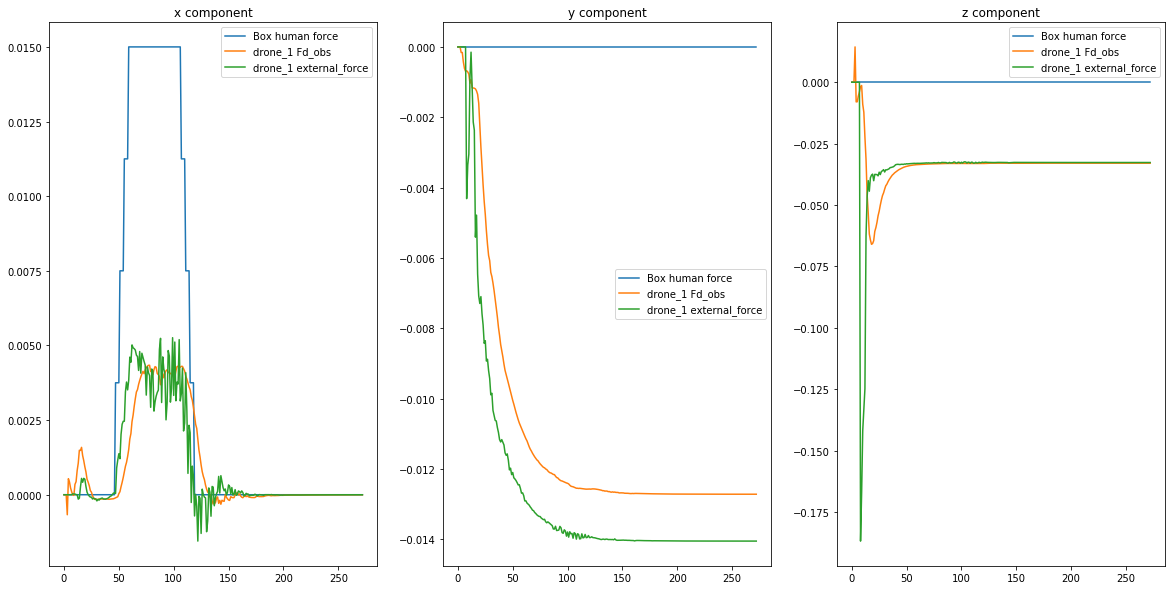

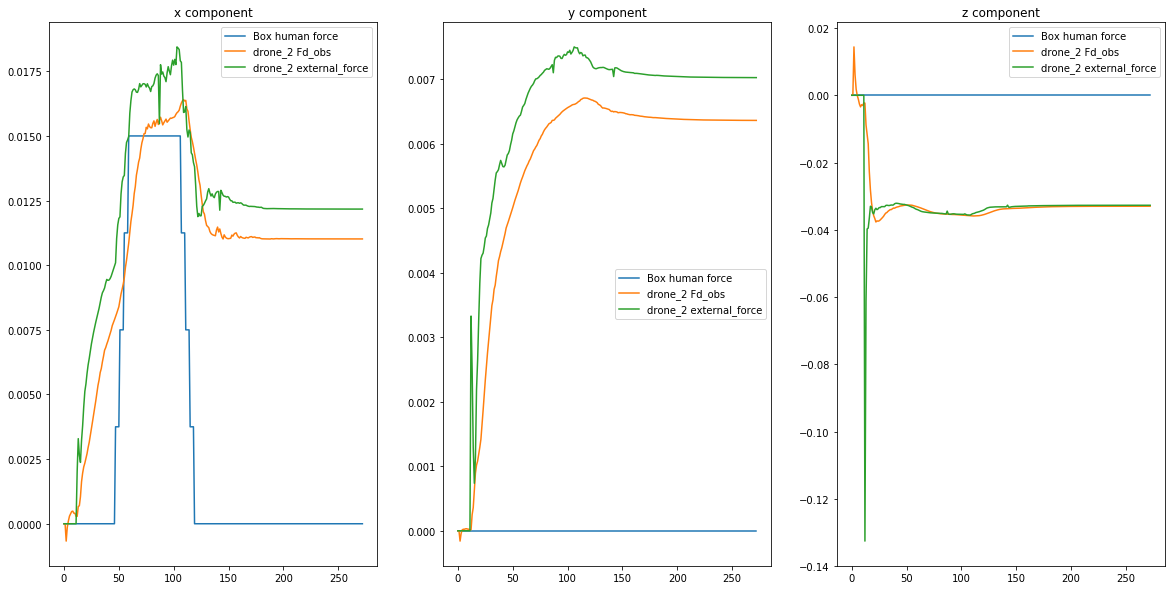

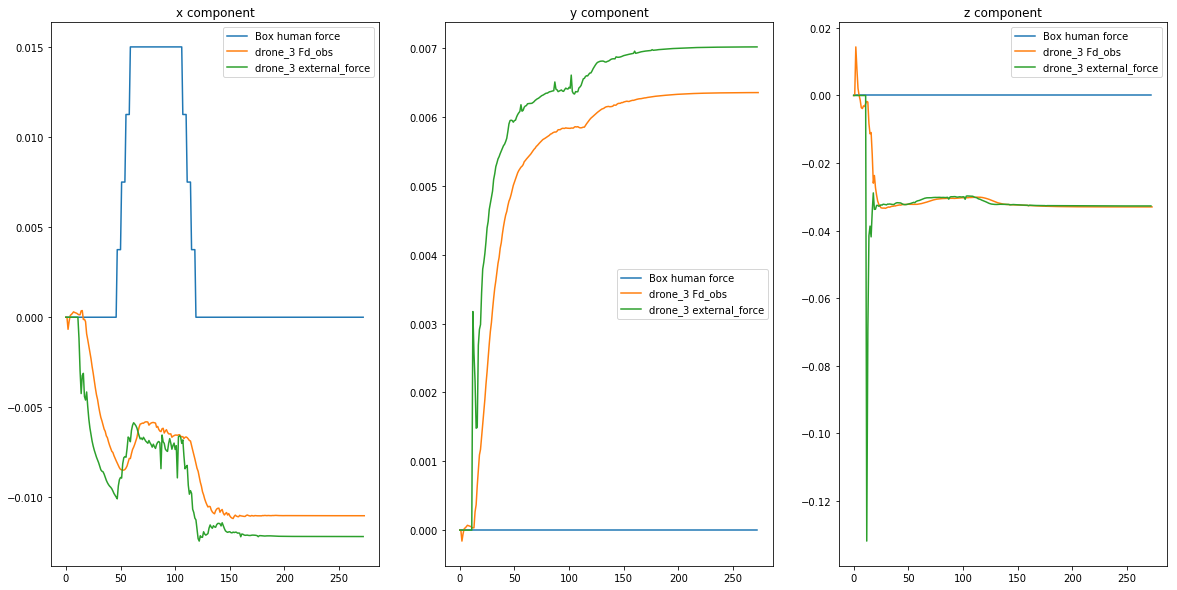

In [63]:
for drone in DRONES:
    forces, names = [processed[BOX][F_HUMAN]], ["Box human force"]
    for name, data in processed.items():
        if name == drone:
    #         forces.append(data[F_HUMAN])
    #         names.append("{} {}".format(name, F_HUMAN))

            forces.append(data[FD_OBS])
            names.append("{} {}".format(name, FD_OBS))

            forces.append(data[EXTERNAL_FORCE])
            names.append("{} {}".format(name, EXTERNAL_FORCE))   
    # for f in forces:
    #     print(f[:, 1])
    plot.plot_vectors(*forces, names=names)



### Estimator Test

In [64]:
curr_drone = DRONES[0]
x_s = processed[curr_drone][SIMULATOR_FULL_STATE][:, 1:]
U = processed[curr_drone][CONTROL][:, 1:]

In [65]:
def get_state_as_controller_state(pos, vel):
    """
    :param pos: Position as nx8 numpy array [timestamp, x, y, z, quaternion]
    :param vel: Velocity as nx7 numpy array [timestamp, x, y, z, w_x, w_y, w_z]
    
    :return: Full state information (nx12) as [linear pos, linear vel, angular pos, angular vel] 
    """
    pos = pos[:, 1:]
    vel = vel[:, 1:]
    quaternions = quaternion.as_quat_array(pos[:, 3:])
    euler = quaternion.as_euler_angles(quaternions)
    n = pos.shape[0]
    state = np.zeros((n, 12))
    state[:, :3] = pos[:, :3]
    state[:, 3:6] = vel[:, :3]
    state[:, 6:9] = euler
    state[:, 9:] = vel[:, 3:]
    return state
    

In [66]:
# get_full_state = lambda drone_num: get_state_as_controller_state(
#     processed[DRONES[drone_num]][POSITION], processed[curr_drone][VELOCITY]
# )
# x_s = get_full_state(0)
def get_full_state(drone_num):
    full_state = processed[DRONES[drone_num]][SIMULATOR_FULL_STATE][:, 1:]
    return np.hstack( (full_state[:, 0:3], full_state[:, 6:9], full_state[:, 3:6], full_state[:, 9:12]) )

# get_full_state = lambda drone_num: 
x_s = get_full_state(0)
x_s2 = get_full_state(1)
x_s3 = get_full_state(2)

In [67]:
x_s.shape

(273, 12)

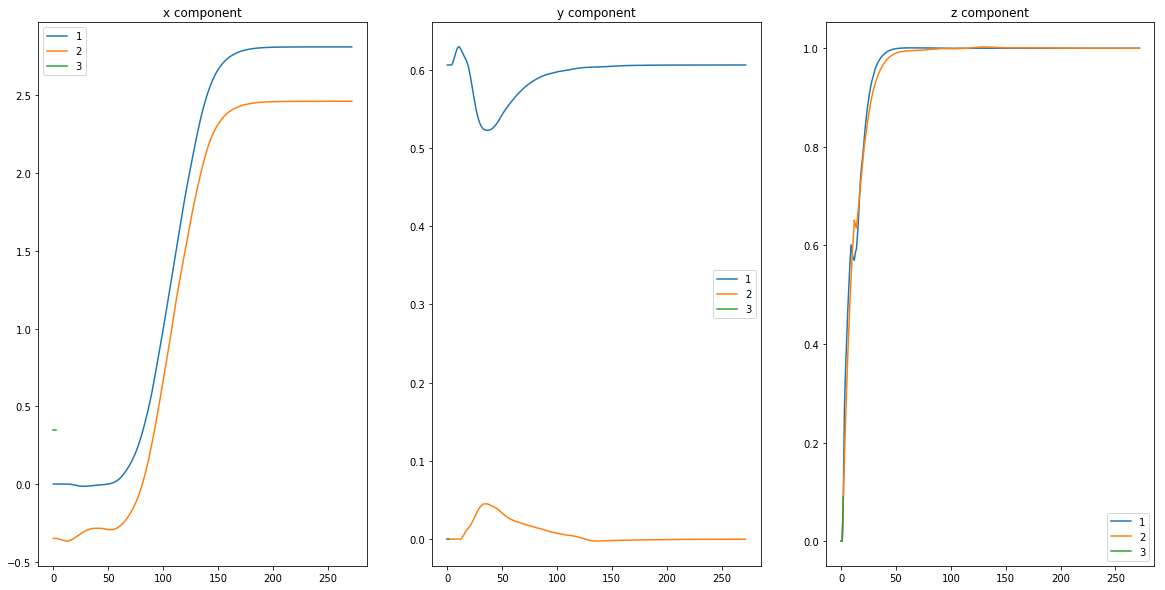

In [68]:
plot.plot_vectors(x_s[:,0:3], x_s2[:, 0:3], x_s3[0:3], names=["1", "2", "3"], index_offset=-1)

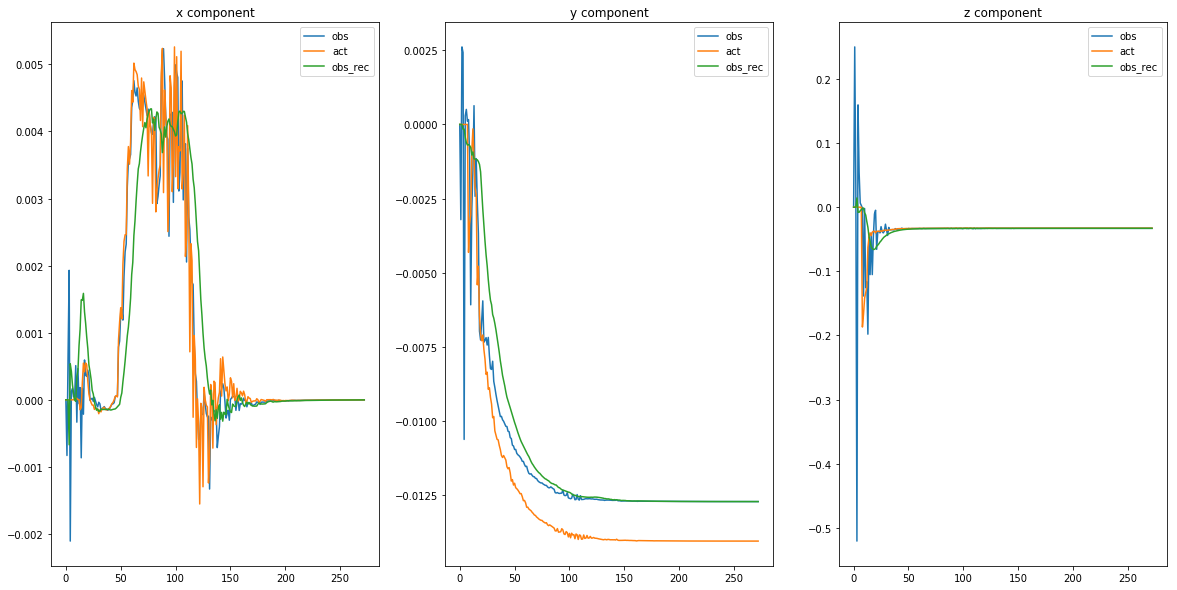

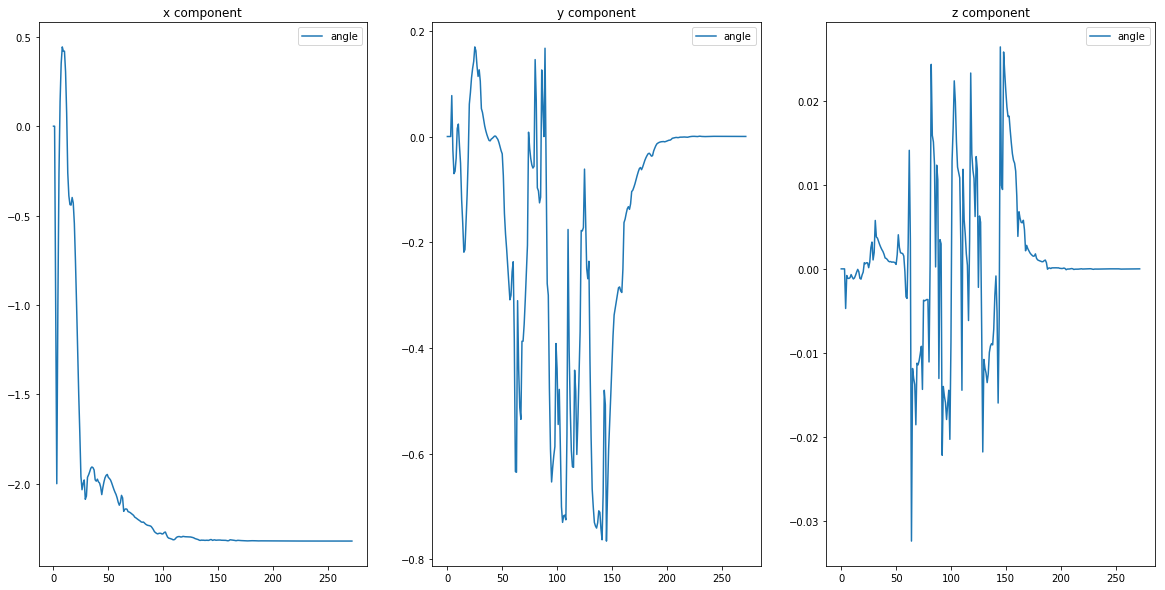

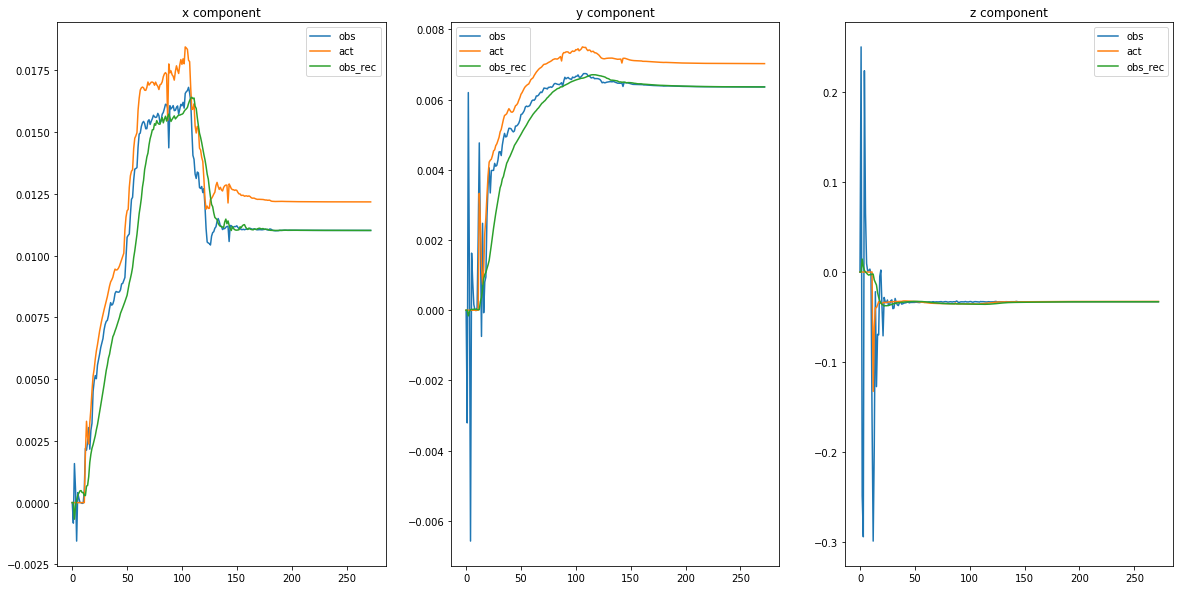

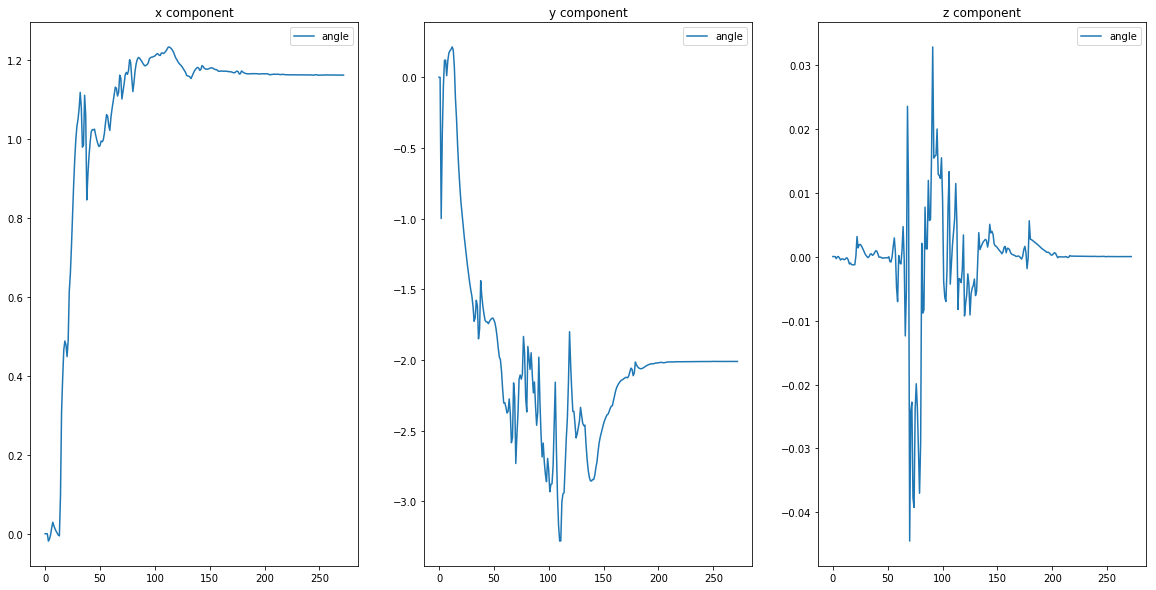

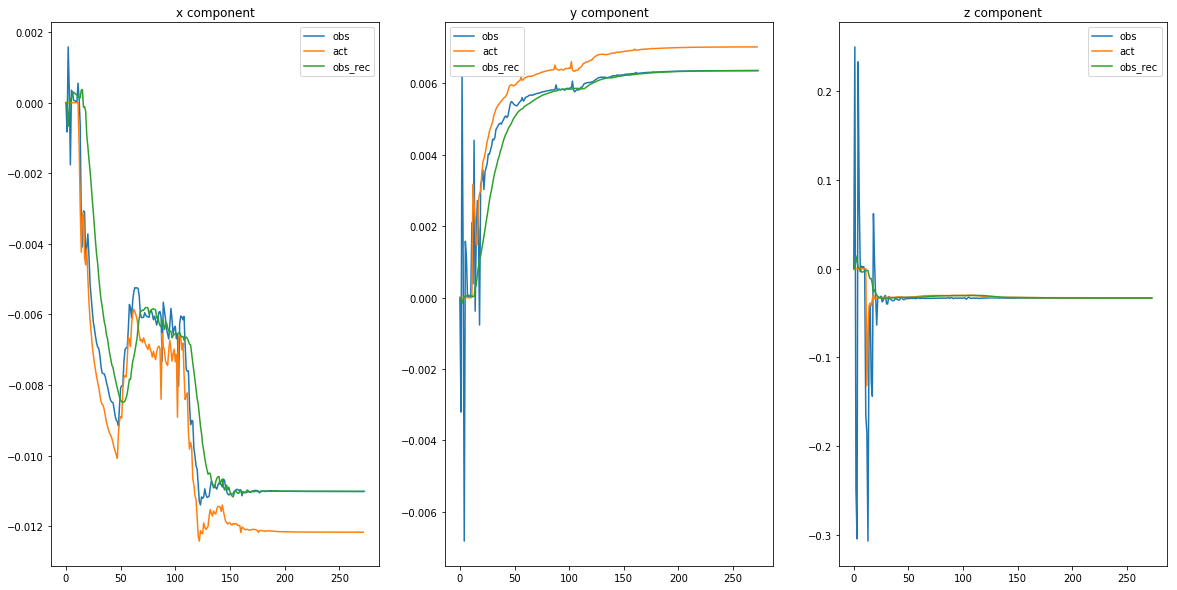

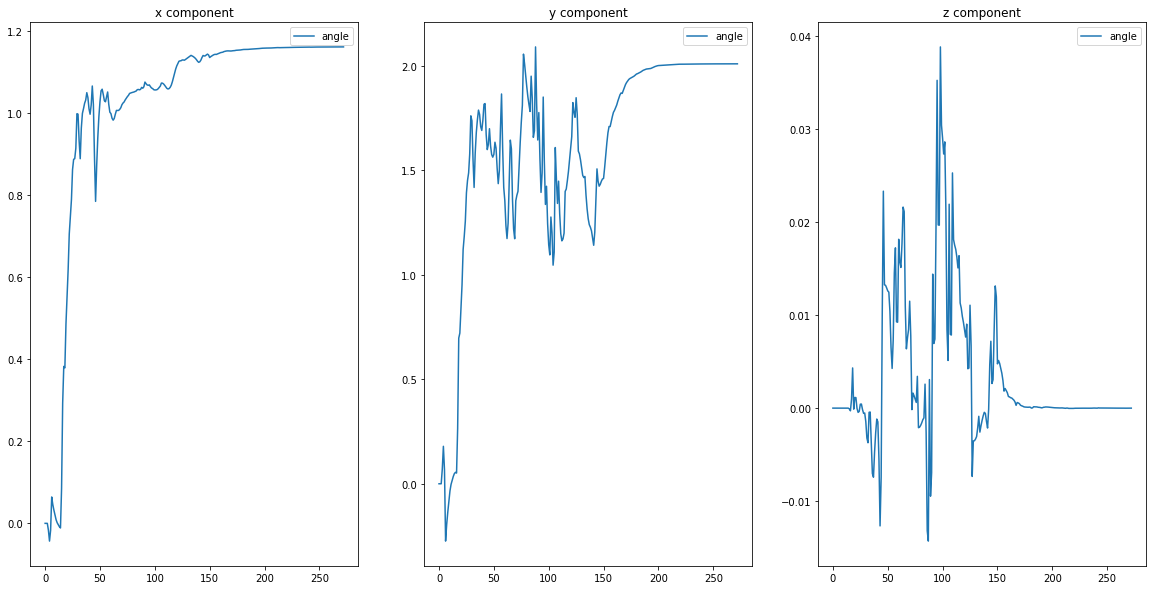

In [59]:
all_x_s = [x_s, x_s2, x_s3]
for x_s_curr, drone in zip(all_x_s ,DRONES):
    x_obs = np.zeros((15,1))

    Bd = np.zeros((12,3))
    Bd[3,0] = T_STEP/M 
    Bd[4,1] = T_STEP/M 
    Bd[5,2] = T_STEP/M 

    Bg= np.zeros((12,1))
    Bg[5] = -GRAVITY
    Bg= T_STEP*Bg.flatten()


    A_obs = np.block([[A,Bd],[np.zeros((3,12)),np.eye(3)]])
    B_obs = np.block([[B],[np.zeros((3,4))]])
    # C = np.block([np.eye(3),np.zeros((3,9))])
    C = np.eye(12)
    Cd = np.zeros((12,3))
    Bg_obs = np.block([[Bg.reshape((12,1))],[np.zeros((3,1))]])
    C_obs = np.block([[C,Cd]])
#     poles = np.array([93.,94,95,96,97,98,99,100,101,102,103,104,105,106,107])/130
#     poles = np.linspace(0, 1, 15)
    poles = np.arange(1, 16) / 130
    sys = scipy.signal.place_poles(A_obs.transpose(),C_obs.transpose(),poles)
    L_obs = sys.gain_matrix.transpose()

    x_obs_vals = []
    for x, u in zip(x_s_curr, U):
        x_obs = np.dot(A_obs,x_obs) + \
            np.dot(B_obs,u.reshape((4,1))) + \
            Bg_obs - \
            L_obs.dot(x_obs[0:12] - x.reshape((12,1)))
        x_obs_vals.append(x_obs.flatten())

    x_obs_vals = np.array(x_obs_vals)
    Fd_obs = x_obs_vals[:, 12:]
    Fd_act = processed[drone][EXTERNAL_FORCE][:, 1:]
    Fd_obs_rec = processed[drone][FD_OBS][:, 1:]
    plot.plot_vectors(Fd_obs, Fd_act, Fd_obs_rec,  names=["obs", "act", "obs_rec"], index_offset=-1)
    plot.plot_vectors(x_s_curr[:, 6:9] * 180 / np.pi, names=["angle"], index_offset=-1)

In [47]:
x_obs_vals.shape, x_obs.shape, x_s.shape

((273, 15), (15, 1), (273, 12))

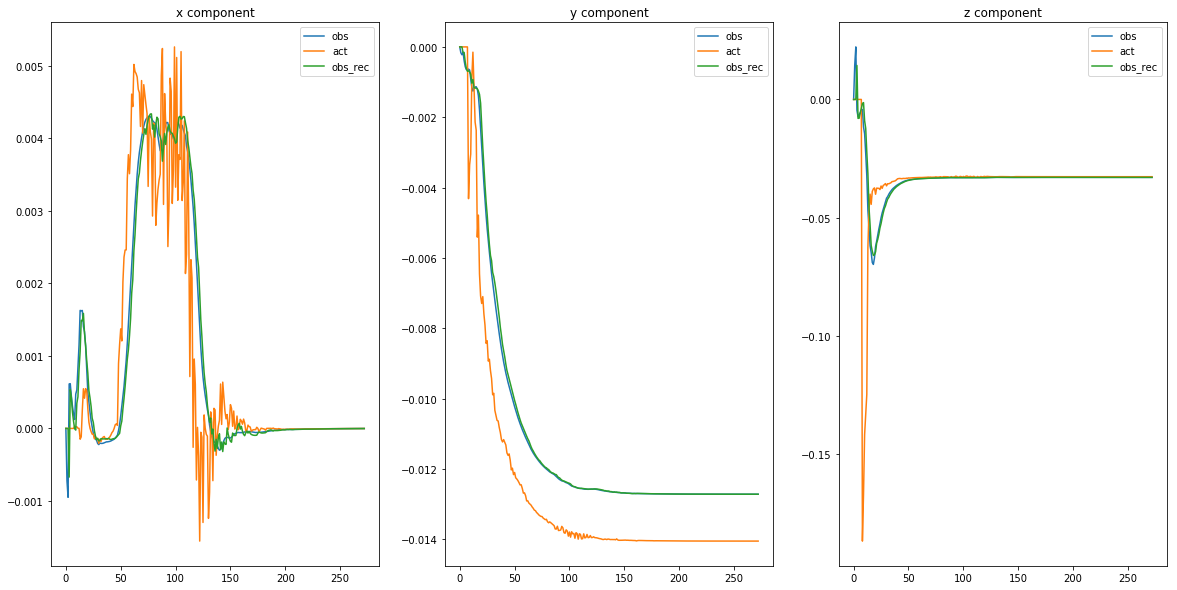